## Small Dataset Full-Image Species Exploration 

In this notebook, we explore a portion of Haiti Tree Project (THTP) captures verified by Cam.

### Dependencies

In [28]:
import torch
import numpy as np
import pandas as pd
import os
import sklearn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import urllib
from PIL import Image

from sklearn.manifold import TSNE

import torchvision.models as models
from torchvision.io import read_image
from torchvision import datasets, transforms as T


### Data Retrieval
 
 
For now, download each image/label pair Cam has specified ([Github link](https://github.com/Greenstand/Tree_Species/tree/master/training)).

In [3]:
datadir = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/cam_training.psv"
baseurl = "https://treetracker-production-images.s3.eu-central-1.amazonaws.com/"
assert os.path.exists(datadir)
data = pd.read_csv(datadir, sep="|", header=None)
data.columns = ["class", "imname"]
data["url"] = baseurl + data["imname"]
data.head(5)

,class,imname,url
0,ACACAURI,2020.11.29.12.18.36_18.285143729299307_-73.564...,https://treetracker-production-images.s3.eu-ce...
1,ACACAURI,2020.11.29.12.18.59_18.285102993249893_-73.564...,https://treetracker-production-images.s3.eu-ce...
2,ACACAURI,2020.11.29.12.47.34_18.290133895352483_-73.557...,https://treetracker-production-images.s3.eu-ce...
3,ACACAURI,2020.11.29.12.50.51_18.29083981923759_-73.5582...,https://treetracker-production-images.s3.eu-ce...
4,ACACAURI,2020.11.29.13.29.55_18.29298411961645_-73.5581...,https://treetracker-production-images.s3.eu-ce...


In [4]:
savepath = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/"
for species in data["class"].unique():
    if not os.path.exists(os.path.join(savepath, species)):
        os.makedirs(os.path.join(savepath, species))
image_saver = lambda df: urllib.request.urlretrieve(df["url"], os.path.join(savepath, df["class"], df["imname"]))
data.apply(image_saver, axis=1)


0      (/home/ec2-user/SageMaker/treetracker-machine-...
1      (/home/ec2-user/SageMaker/treetracker-machine-...
2      (/home/ec2-user/SageMaker/treetracker-machine-...
3      (/home/ec2-user/SageMaker/treetracker-machine-...
4      (/home/ec2-user/SageMaker/treetracker-machine-...
                             ...                        
383    (/home/ec2-user/SageMaker/treetracker-machine-...
384    (/home/ec2-user/SageMaker/treetracker-machine-...
385    (/home/ec2-user/SageMaker/treetracker-machine-...
386    (/home/ec2-user/SageMaker/treetracker-machine-...
387    (/home/ec2-user/SageMaker/treetracker-machine-...
Length: 388, dtype: object

388  total samples
Class breakdown
          imname  url
class                
ACACAURI     111  111
ANACOCCI      53   53
CATALONG      75   75
MANGINDI     149  149
4  classes


Text(0.5, 1.0, 'Count per class')

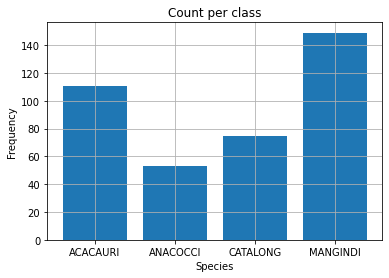

In [17]:
print (data.shape[0], " total samples")
print ("Class breakdown")
count_by_class = data.groupby("class").aggregate("count")
print (count_by_class)
num_classes = data["class"].unique().shape[0]
print (num_classes, " classes found")
plt.bar(count_by_class.index, count_by_class["imname"])
plt.grid()
plt.xlabel("Species")
plt.ylabel("Frequency")
plt.title("Count per class")

In [6]:
arrs = []
labels = []
for species in data["class"].unique():
    for img in os.listdir(os.path.join(savepath, species)):
        if os.path.splitext(os.path.join(savepath, species, img))[1].lower() in [".jpg", ".png"]:
            arrs.append(Image.open(os.path.join(savepath, species, img)).resize((224, 224)))
            labels.append(species)
            


In [7]:
X = np.vstack([np.asarray(img).flatten() for img in arrs])
X_embedded = TSNE(n_components=2, perplexity=30.0, learning_rate=25.0, n_iter=10000).fit_transform(X)

In [8]:
tsne_result = pd.DataFrame(X_embedded)
tsne_result["class"] = labels
tsne_result.columns = ["x0", "x1", "class"]
colors = np.linspace(0, 1, len(data["class"].unique()))
colordict = dict(zip(data["class"].unique(), colors))  
tsne_result["Color"] = tsne_result["class"].apply(lambda x: colordict[x])

In [9]:
print (tsne_result.head(5))

         x0        x1     class  Color
0  1.211671  0.520156  ACACAURI    0.0
1 -2.495020  1.715525  ACACAURI    0.0
2  0.939667  0.531585  ACACAURI    0.0
3  0.131321  1.433267  ACACAURI    0.0
4 -0.714383  0.572061  ACACAURI    0.0


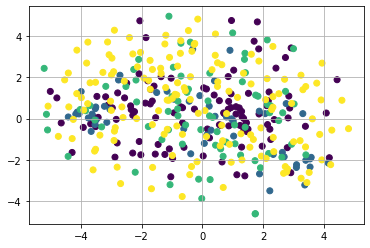

In [10]:
plt.grid()
plt.scatter(tsne_result["x0"], tsne_result["x1"], c=tsne_result["Color"])


In [26]:

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            

transform = T.Compose([T.Resize(512), T.CenterCrop(299), T.ToTensor()])

inception = models.inception_v3(pretrained=True)
set_parameter_requires_grad(inception, feature_extracting=True)
num_ftrs = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = torch.nn.Linear(num_ftrs, num_classes)
# Handle the primary net
num_ftrs = inception.fc.in_features
inception.fc = torch.nn.Linear(num_ftrs,num_classes)

params_to_update = []
for name, param in inception.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss()
inception = inception.to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

In [12]:
preds = [inception(transform(img)[None, ...]).detach().numpy() for img in arrs]

In [27]:
print (data.head(5))

      class                                             imname  \
0  ACACAURI  2020.11.29.12.18.36_18.285143729299307_-73.564...   
1  ACACAURI  2020.11.29.12.18.59_18.285102993249893_-73.564...   
2  ACACAURI  2020.11.29.12.47.34_18.290133895352483_-73.557...   
3  ACACAURI  2020.11.29.12.50.51_18.29083981923759_-73.5582...   
4  ACACAURI  2020.11.29.13.29.55_18.29298411961645_-73.5581...   

                                                 url  
0  https://treetracker-production-images.s3.eu-ce...  
1  https://treetracker-production-images.s3.eu-ce...  
2  https://treetracker-production-images.s3.eu-ce...  
3  https://treetracker-production-images.s3.eu-ce...  
4  https://treetracker-production-images.s3.eu-ce...  


In [38]:
class HaitiDataset(torch.utils.data.Dataset):
    def __init__(self, df, loadpath, transform, encoding):
        '''
        A dataset with image names, classes, and a provided loading path to load images from
        '''
        self.loadpath = loadpath
        self.data = df
        self.n_classes = self.data["class"].unique().shape[0]
        self.transform = transform
        self.numerical_encoding = dict(zip(list(self.data["class"].unique()), list(range(self.n_classes))))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        img_path = os.path.join(loadpath, self.data.iloc[i, :]["imname"])
        label = self.data.iloc[i, :]["class"]
        img = self.transform(read_image(img_path))
        label = torch.nn.functional.one_hot(label, num_classes=self.n_classes)
        return image, label
        
        

In [39]:
dataset = HaitiDataset(data, savepath, transform, None)
dataloader = DataLoader(dataset, )

In [40]:
for 

ModuleAttributeError: 'Inception3' object has no attribute 'fit'